In [162]:
import torch
import torchvision
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# hack for MNIST download
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [19]:
def transform(data):
    data = torch.tensor(data.getdata(), dtype=torch.float64)
    return torch.floor(data / 128.).squeeze(axis=-1)

In [20]:
full_train_set = torchvision.datasets.MNIST('.', train=True, transform=transform, download=True)
full_test_set = torchvision.datasets.MNIST('.', train=False, transform=transform, download=True)

In [106]:
class NaiveBayesClassifier:
    def __init__(self, eps=1e-9):
        self.eps = eps
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        self.classes = list(set(self.y_train))
        self.classes_pixel_prob = dict.fromkeys(self.classes)
        self.classes_prob = dict.fromkeys(self.classes)
        
        self.pixel_prob = (self.X_train.sum(axis=0) / self.X_train.sum()) + self.eps
        
        for cl in self.classes:
            trn = self.X_train[[True if i == cl else False for i in self.y_train]]
            
            self.classes_pixel_prob[cl] = (trn.sum(axis=0) / trn.sum()) + eps
            
            self.classes_prob[cl] = torch.tensor(sum([True if i == cl else False for i in self.y_train]) / len(y_train))
    
    def predict(self, X_test):
        self.predict_proba(X_test)
        self.pred = []
        
        for p in self.pred_proba:
            self.pred.append(max(p, key=p.get))
            
        return self.pred
    
    def predict_proba(self, X_test):
        self.pred_proba = []
        #(test_one * p_pixel_one)[test_one != 0].log().sum() + p_one.log()
        
        for smp in X_test:
            smp_pix = [smp != 0]
            
            probs = {}
            for cl in self.classes:
                prob = (smp * self.classes_pixel_prob[cl])[smp_pix].log().sum() + self.classes_prob[cl].log()
                probs[cl] = prob.item()
            
            self.pred_proba.append(probs)

        return self.pred_proba

    def score(self, X_test, y_test):
        self.predict(X_test)
        
        return (np.array(self.pred) == np.array(y_test)).sum()/len(y_test)

In [111]:
X_train = torch.stack([itm[0] for itm in full_train_set if itm[1] in [1, 2]]).cuda()
y_train = [itm[1] for itm in full_train_set if itm[1] in [1, 2]]
X_test = torch.stack([itm[0] for itm in full_test_set if itm[1] in [1, 2]]).cuda()
y_test = [itm[1] for itm in full_test_set if itm[1] in [1, 2]]

In [114]:
clf = NaiveBayesClassifier()
clf.fit(X_train, y_train)
clf.classes

[1, 2]

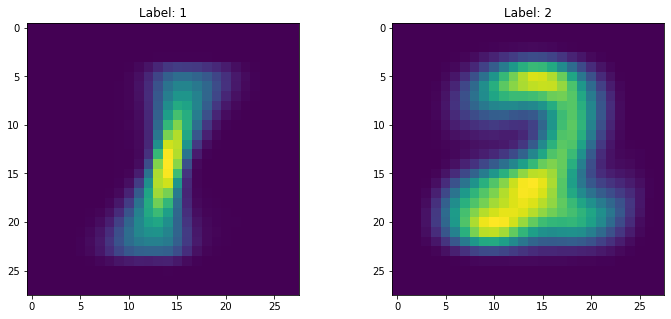

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(clf.classes_pixel_prob[1].cpu().numpy().reshape(28, 28))
axes[0].set_title('Label: 1')
axes[1].imshow(clf.classes_pixel_prob[2].cpu().numpy().reshape(28, 28))
axes[1].set_title('Label: 2')
    
plt.show()

In [118]:
clf.score(X_test, y_test)

0.9672358098754038

In [132]:
err = np.array(clf.pred) != np.array(y_test)

In [133]:
err10_im = X_test[err][:10]
err10_pr = np.array(clf.pred)[err][:10]

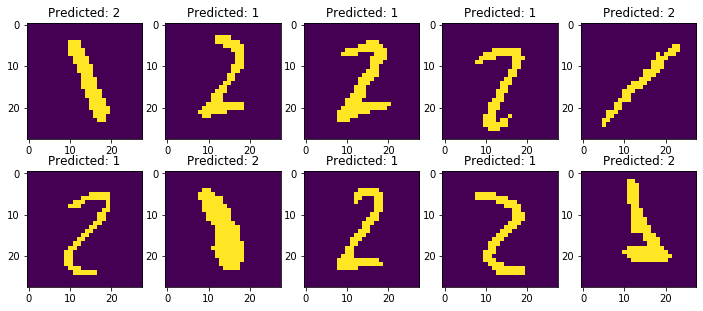

In [134]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(err10_im[i].cpu().numpy().reshape(28, 28))
    ax.set_title(f'Predicted: {err10_pr[i]}')
    
plt.show()

In [143]:
y_test_err = np.array(y_test)[err]

In [145]:
y_err_cnt = Counter(y_test_err)
y_err_cnt

Counter({1: 43, 2: 28})

In [146]:
y_cnt = Counter(y_test)
y_cnt

Counter({2: 1032, 1: 1135})

In [149]:
for i in [1, 2]:
    print(f'Error probability for {i}: {y_err_cnt[i]/y_cnt[i]}')

Error probability for 1: 0.03788546255506608
Error probability for 2: 0.027131782945736434


In [150]:
X_train_full = torch.stack([itm[0] for itm in full_train_set]).cuda()
y_train_full = [itm[1] for itm in full_train_set]
X_test_full = torch.stack([itm[0] for itm in full_test_set]).cuda()
y_test_full = [itm[1] for itm in full_test_set]

In [151]:
clf_full = NaiveBayesClassifier()
clf_full.fit(X_train_full, y_train_full)
clf_full.classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

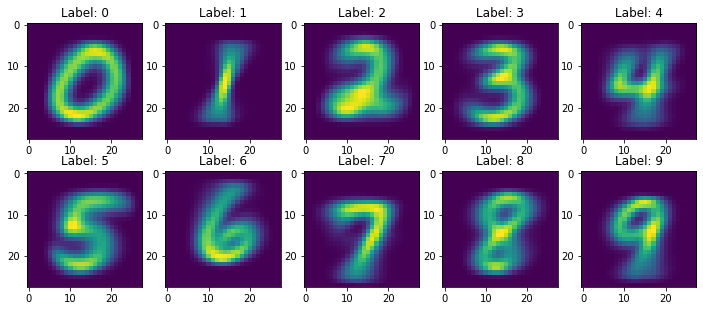

In [152]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(clf_full.classes_pixel_prob[i].cpu().numpy().reshape(28, 28))
    ax.set_title(f'Label: {i}')
    
plt.show()

In [153]:
clf_full.score(X_test_full, y_test_full)

0.8357

In [154]:
err_full = np.array(clf_full.pred) != np.array(y_test_full)

In [156]:
err_full10_im = X_test_full[err_full][:10]
err_full10_pr = np.array(clf_full.pred)[err_full][:10]

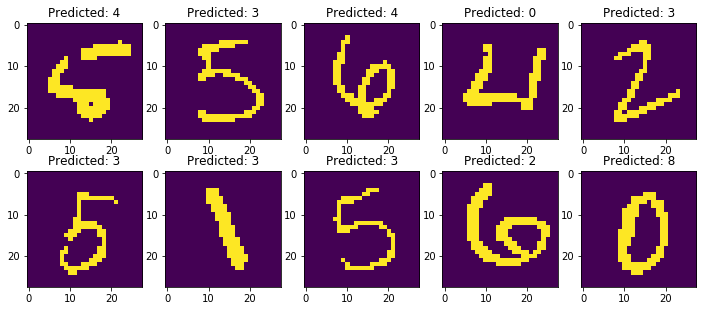

In [157]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(err_full10_im[i].cpu().numpy().reshape(28, 28))
    ax.set_title(f'Predicted: {err_full10_pr[i]}')
    
plt.show()

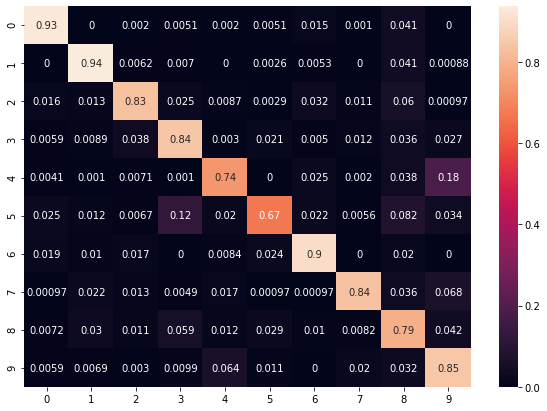

In [179]:
cfm = confusion_matrix(y_test_full, clf_full.pred, labels=list(range(0, 10)), normalize='true')
df_cm = pd.DataFrame(cfm, index=list(range(0, 10)), columns=list(range(0, 10)))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)